
# Mutual Information

## Definition
Mutual Information (MI) measures the amount of information that one random variable contains about another.

### From KL Divergence
If $X$ and $Y$ are discrete random variables, their mutual information is defined as:

$$
I(X; Y) = D_{\text{KL}}(p(x, y) \,||\, p(x) p(y))
$$

This tells us how different the joint distribution is from the product of the marginals (which assumes independence).

### From Entropy
Another equivalent definition of mutual information is:

$$
I(X; Y) = H(X) - H(X | Y) = H(Y) - H(Y | X)
$$
or:
$$
I(X; Y) = H(X) + H(Y) - H(X, Y)
$$

where:
- $H(X)$: entropy of $X$
- $H(X|Y)$: conditional entropy of $X$ given $Y$
- $H(X, Y)$: joint entropy

Mutual Information is always **non-negative**, and zero if and only if $X$ and $Y$ are independent.



---

###  Mutual Information for Continuous Variables

In the **continuous case**, Mutual Information (MI) is defined similarly, but involves **differential entropy** instead of discrete entropy.

#### Definition

Let $X$ and $Y$ be continuous random variables with joint density $p(x, y)$ and marginals $p(x)$, $p(y)$. Then:

$$
I(X; Y) = \iint p(x, y) \log \left( \frac{p(x, y)}{p(x) p(y)} \right) dx\,dy
$$

This is the **Kullback–Leibler divergence** between the joint distribution $p(x, y)$ and the product of marginals $p(x)p(y)$, as in the discrete case.

#### Properties

* MI is **non-negative**: $I(X; Y) \geq 0$, with equality **if and only if** $X$ and $Y$ are independent.
* Unlike correlation, MI captures **any type of dependence**, linear or non-linear.
* Estimating MI in continuous spaces is **harder** than in discrete cases and typically requires approximation.

#### Estimation Methods

Since exact computation requires knowing the joint and marginal densities, practical estimation uses techniques such as:

* **Binning** (discretization): Turn continuous data into discrete bins, then apply discrete MI.
* **k-nearest neighbors** (KSG estimator, Kraskov et al.): A popular method that avoids explicit density estimation. The method defined in Scikit-learn's ***mutual_info_regression*** is based on this approach.
* **Kernel Density Estimation (KDE)**: Estimate densities and use numerical integration.



---

The **range of values for Mutual Information (MI)** depends on the nature of the variables (discrete vs. continuous) and whether the MI is normalized or not:



###  **Mutual Information**

#### **Discrete Variables**

* **Range**:

  $$
  0 \leq I(X; Y) \leq \min(H(X), H(Y))
  $$
* The maximum MI is when $X$ perfectly determines $Y$, or vice versa.
* The upper bound is the **entropy** of the least informative variable.

#### **Continuous Variables**

* **Range**:

  $$
  0 \leq I(X; Y) < \infty
  $$
* In theory, MI between continuous variables can be arbitrarily large, especially with **low noise** or **strong deterministic relationships**.
* **No finite upper bound** unless the domain or resolution is limited (e.g., via discretization).






## Small Example (Discrete Variables)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import differential_entropy
import pandas as pd

In [ ]:
# Discrete example
X = [0, 0, 1, 1]
Y = [0, 0, 1, 1]
Z = [1, 1, 1, 1]

# MI should be high between X and Y
print("Mutual Information (X, Y):", mutual_info_score(X, Y))
print("Mutual Information (X, Z):", mutual_info_score(X, Z))


Mutual Information (X, Y): 0.6931471805599453
Mutual Information (X, Z): 0.0


## Mutual Information vs Correlation


Correlation captures *linear* dependence, while Mutual Information captures *any* dependency, including non-linear.

Let's visualize several datasets and compare correlation and MI.


In [ ]:
# Generate synthetic datasets
np.random.seed(42)
n = 500
scenarios = []

# 1. Independent (no correlation, no MI)
x1 = np.random.randn(n)
y1 = np.random.randn(n)

# 2. Linear relation (high correlation and MI)
x2 = np.random.randn(n)
y2 = 2 * x2 + 0.1 * np.random.randn(n)

# 3. Nonlinear relation (zero correlation, high MI)
x3 = np.random.randn(n)
y3 = np.sin(6 * np.pi * x3**2 - x3)

# 4. Another nonlinear relation
x4 = np.random.randn(n)
y4 = (np.abs(x4) > 0.5).astype(float) + np.random.randn(n)*0.01

# 5. Perfect inverse (negative correlation, high MI)
x5 = np.random.randn(n)
y5 = -x5


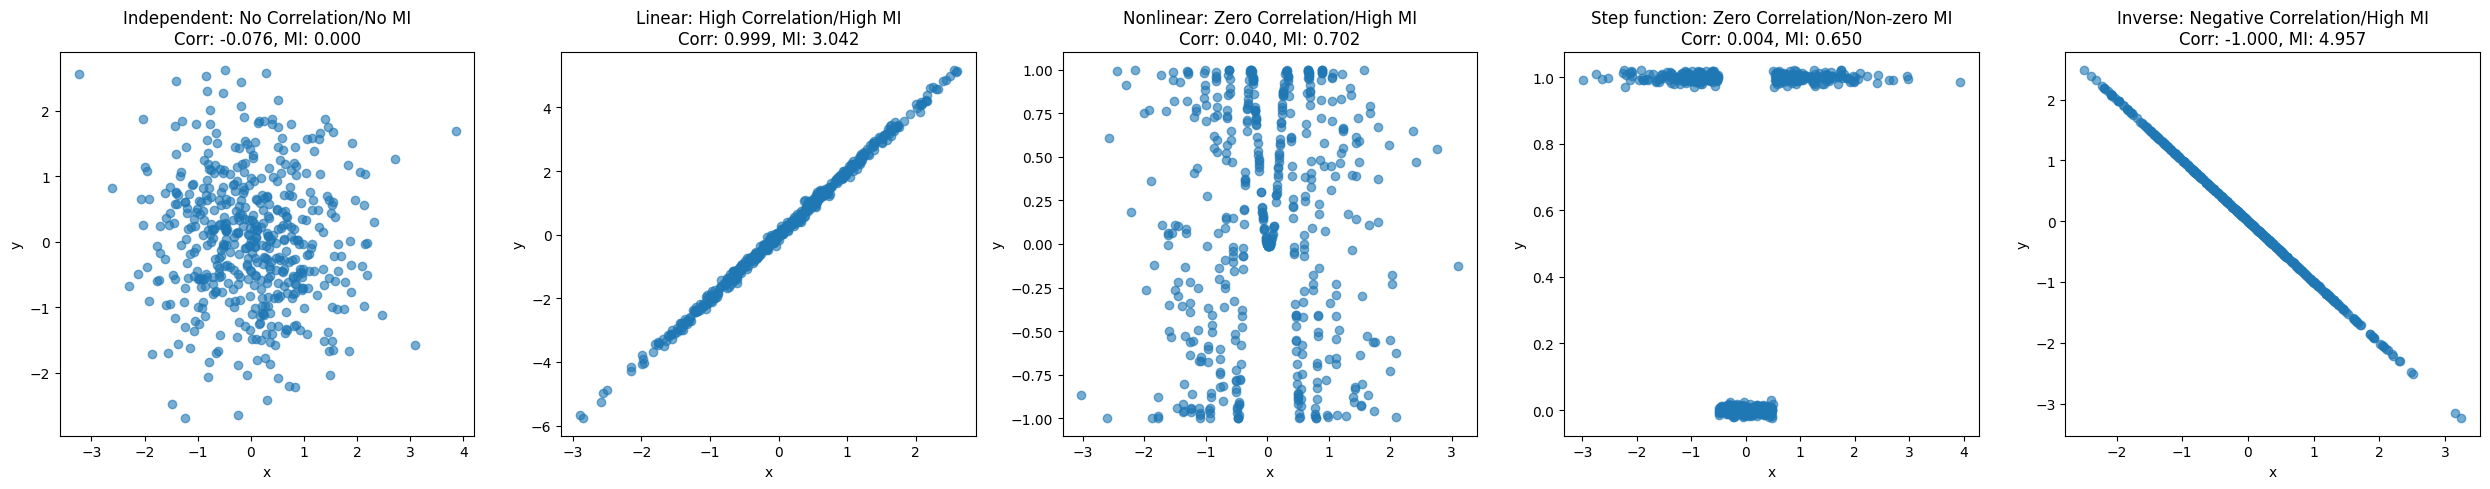

In [ ]:
# Create figure with subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Plot each dataset with metrics in title
datasets = [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5)]
titles = [
    "Independent: No Correlation/No MI",
    "Linear: High Correlation/High MI",
    "Nonlinear: Zero Correlation/High MI",
    "Step function: Zero Correlation/Non-zero MI",
    "Inverse: Negative Correlation/High MI"
]

for ax, (x, y), title in zip(axes, datasets, titles):
    # Calculate Pearson correlation
    corr, _ = pearsonr(x, y)

    # Calculate Mutual Information using k-nearest neighbors
    mi = mutual_info_regression(x.reshape(-1, 1), y, n_neighbors=3, random_state=42)[0]

    # Plot scatter
    ax.scatter(x, y, alpha=0.6)
    ax.set_title(f"{title}\nCorr: {corr:.3f}, MI: {mi:.3f}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()


- Correlation only measures **linear** relationships, and can be zero for **non-linear** dependencies.
- Mutual Information captures **all kinds** of dependencies, linear and non-linear.
- MI is always non-negative, while correlation can be negative.



## Understanding how to Scikit-learn approximates continuous MI


Mutual Information may be defined in terms of entropy:

$$
I(X; Y) = H(X) + H(Y) - H(X, Y)
$$

So if you can estimate **entropy**, you can estimate **mutual information**.

The k-NN based **Kraskov estimator** of mutual information relies on estimating each of these entropies using **k-NN density estimation**.



### Goal: Estimate Entropy via k-NN

Let’s say we have $n$ i.i.d. samples $\{x_1, \dots, x_n\} \subset \mathbb{R}^d$ from an unknown distribution $p(x)$.

The **differential entropy** of $X$ is:

$$
H(X) = -\int p(x) \log p(x) \, dx
$$

We **don’t know** $p(x)$, but we can **estimate it using k-NN density estimation**.

### k-NN Entropy Estimator

Let $\varepsilon_i$ be the distance from $x_i$ to its $k$-th nearest neighbor.

Then the **k-NN estimate of entropy** is:

$$
\hat{H}(X) = \psi(n) - \psi(k) + \log V_d + \frac{d}{n} \sum_{i=1}^n \log \varepsilon_i
$$

Where:

* $\psi$ is the **digamma function**,
* $V_d$ is the **volume of the unit ball** in $\mathbb{R}^d$,
* $\varepsilon_i$ is the k-th neighbor distance for point $x_i$,
* $d$ is the dimension.

This arises from plugging the **k-NN density estimate** into the entropy formula:

$$
p(x_i) \approx \frac{k}{n V_d \varepsilon_i^d} \quad \Rightarrow \quad \log p(x_i) \approx \log k - \log n - \log V_d - d \log \varepsilon_i
$$

Then average over all $i$ and take the negative.

## Kraskov’s Mutual Information Estimator

Kraskov et al. (2004) observed that estimating MI via:

$$
I(X; Y) = H(X) + H(Y) - H(X, Y)
$$

is **numerically unstable** because small entropy estimation errors can compound.

Instead, they proposed a **direct estimator**, still based on k-NN, but more robust.

### Kraskov’s Trick:

1. For each point $(x_i, y_i)$, compute $\varepsilon_i$, the distance to the $k$-th nearest neighbor **in the joint space $(X, Y)$**, using **maximum norm**:

$$
\| (x_i, y_i) - (x_j, y_j) \|_{\infty} = \max(|x_i - x_j|, |y_i - y_j|)
$$

2. Count how many neighbors fall **within $\varepsilon_i$** in:

   * $X$-space: $n_{x,i}$
   * $Y$-space: $n_{y,i}$

3. Plug into the Kraskov MI estimator:

$$
I(X; Y) = \psi(k) - \frac{1}{n} \sum_{i=1}^n \left[ \psi(n_{x,i} + 1) + \psi(n_{y,i} + 1) \right] + \psi(n)
$$

* This avoids computing densities directly.
* Instead of using $\log p(x)$, it uses **neighbor counts** as a proxy.

This estimator is robust, adaptive, and works well even with few samples or nonlinear dependencies.

---

It is worth mentioning that the function **`mutual_info_regression`** from **Scikit-learn** documentation does not explicitly evaluate the digamma function:

“The mutual information between each feature and the target is estimated using nonparametric methods based on entropy estimation from k-nearest neighbors distances. It relies on methods described in Kraskov et al. (2004), but the digamma function is not evaluated explicitly.”

Also, **`mutual_info_regression`** only is capable of computing Mutual Information for scalar-valued target variables.



1. Toy problem 1
  - $\theta_1 \sim \mathcal{N}(0, 1)$
  - $\theta_2 \sim \mathcal{N}(0, 1)$
  - $\text{QoI} = [\text{QoI}_1(\theta_1, \theta_2), \text{QoI}_2(\theta_1, \theta_2)]$.
  - Find Mutual Information between $[\theta_1, \theta_2]$ and $\text{QoI}$ and its components separetely. See the possible interactions by defining appropriate algebraic expressions for $\text{QoI}_1(\theta_1, \theta_2)$ and $\text{QoI}_2(\theta_1, \theta_2)$.



In [ ]:
np.random.seed(41)

# 1. Sample
n = 1000
theta1 = np.random.randn(n)
theta2 = np.random.randn(n)

# 2. Compute QoIs
d_qoi1 = theta2 - 2 * np.sin(theta1 * 4)
d_qoi2 = -theta1**2 * np.sign(theta2)

# Stack features for MI estimation
theta = np.vstack([theta1, theta2]).T

# 3. Compute MI and correlation for each QoI
mi_qoi1 = mutual_info_regression(theta, d_qoi1, n_neighbors=3, random_state=0)
mi_qoi2 = mutual_info_regression(theta, d_qoi2, n_neighbors=3, random_state=0)

# Pairwise correlation between each feature and each QoI
corr_theta1_qoi1, _ = pearsonr(theta1, d_qoi1)
corr_theta2_qoi1, _ = pearsonr(theta2, d_qoi1)
corr_theta1_qoi2, _ = pearsonr(theta1, d_qoi2)
corr_theta2_qoi2, _ = pearsonr(theta2, d_qoi2)

# 3b. Compute MI and correlation between outputs
mi_qoi1_qoi2 = mutual_info_regression(d_qoi1.reshape(-1, 1), d_qoi2, n_neighbors=3, random_state=0)
corr_qoi1_qoi2, _ = pearsonr(d_qoi1, d_qoi2)

# 4. Present MI results
print(f"MI(theta1, QoI1) = {mi_qoi1[0]:.4f}")
print(f"MI(theta2, QoI1) = {mi_qoi1[1]:.4f}")
print(f"MI(theta1, QoI2) = {mi_qoi2[0]:.4f}")
print(f"MI(theta2, QoI2) = {mi_qoi2[1]:.4f}")
print(f"MI(QoI1, QoI2) = {mi_qoi1_qoi2[0]:.4f}\n")

# 4b. Present covariance results
print(f"corr(theta1, QoI1) = {corr_theta1_qoi1:.4f}")
print(f"corr(theta2, QoI1) = {corr_theta2_qoi1:.4f}")
print(f"corr(theta1, QoI2) = {corr_theta1_qoi2:.4f}")
print(f"corr(theta2, QoI2) = {corr_theta2_qoi2:.4f}")
print(f"corr(QoI1, QoI2) = {corr_qoi1_qoi2:.4f}")




MI(theta1, QoI1) = 0.5319
MI(theta2, QoI1) = 0.6620
MI(theta1, QoI2) = 3.7121
MI(theta2, QoI2) = 0.5595
MI(QoI1, QoI2) = 0.5157

corr(theta1, QoI1) = -0.0111
corr(theta2, QoI1) = 0.5731
corr(theta1, QoI2) = -0.0204
corr(theta2, QoI2) = -0.4676
corr(QoI1, QoI2) = -0.2900


In [ ]:
d_qoi2.shape

(1000,)

2. Toy problem 2
  - Logistic equation, check how MI $\text{QoI}(t) = N(t)$ changes over time.
   $$N(t) = K \left(1 + \frac{K-N_0}{N_0} \exp(-\alpha t) \right)^{-1}$$

   Inputs: $\alpha, K, N_0$. Evaluate $\text{QoI}$ in multiple times $t_1, t_2, t_3...$ to generate $\text{QoI}$ vector.

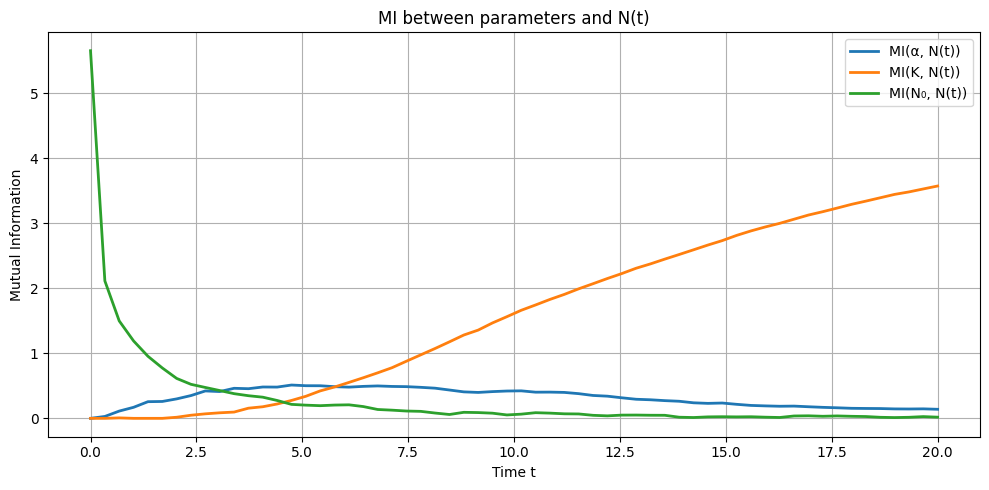

In [ ]:
# 1. Sample inputs
n = 1000
alpha = np.random.uniform(0.1, 1.0, n)
K = np.random.uniform(50, 150, n)
N0 = np.random.uniform(1, 20, n)
theta = np.stack([alpha, K, N0], axis=1)

# 2. Time vector
t_vals = np.linspace(0, 20, 60)
num_t = len(t_vals)

# 3. Compute N(t) for each time and store outputs
N_matrix = np.zeros((n, num_t))
for idx, t in enumerate(t_vals):
    N_matrix[:, idx] = K / (1 + ((K - N0) / N0) * np.exp(-alpha * t))

# 4. Mutual Information between parameters and each N(t)
mi_params_vs_time = np.array([
    mutual_info_regression(theta, N_matrix[:, idx], n_neighbors=3, random_state=0)
    for idx in range(num_t)
])

# 5. Mutual Information between N(tᵢ) and N(tⱼ)
mi_outputs = np.zeros((num_t, num_t))
mi_pairs = [
    (i, j, mutual_info_regression(N_matrix[:, i].reshape(-1, 1),
                                   N_matrix[:, j],
                                   n_neighbors=3, random_state=0)[0])
    for i in range(num_t) for j in range(i, num_t)
]
for i, j, mi in mi_pairs:
    mi_outputs[i, j] = mi_outputs[j, i] = mi

# 6. Plot MI between parameters and N(t)
plt.figure(figsize=(10, 5))
plt.plot(t_vals, mi_params_vs_time[:, 0], label='MI(α, N(t))', lw=2)
plt.plot(t_vals, mi_params_vs_time[:, 1], label='MI(K, N(t))', lw=2)
plt.plot(t_vals, mi_params_vs_time[:, 2], label='MI(N₀, N(t))', lw=2)
plt.xlabel('Time t')
plt.ylabel('Mutual Information')
plt.title('MI between parameters and N(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


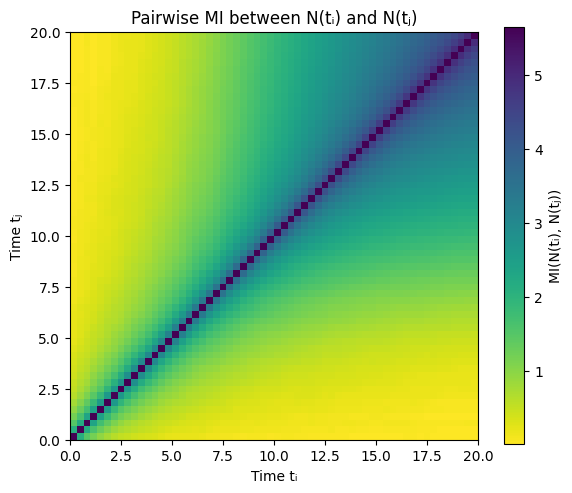

In [ ]:

# 7. Plot MI matrix between outputs
plt.figure(figsize=(6, 5))
plt.imshow(mi_outputs, cmap='viridis_r', origin='lower',
           extent=[t_vals[0], t_vals[-1], t_vals[0], t_vals[-1]])
plt.colorbar(label='MI(N(tᵢ), N(tⱼ))')
plt.title('Pairwise MI between N(tᵢ) and N(tⱼ)')
plt.xlabel('Time tᵢ')
plt.ylabel('Time tⱼ')
plt.tight_layout()
plt.show()

In [ ]:
mi_pairs_ = np.array([
    mutual_info_regression(N_matrix[:, [1, -1]],
                                   N_matrix[:, j],
                                   n_neighbors=3, random_state=0)
    for j in range(1, len(t_vals))]
)


In [ ]:
mi_pairs_norm = np.linalg.norm(mi_pairs_, axis=1, ord = 1)
idx = np.argmin(mi_pairs_norm) + 1
idx

np.int64(12)

In [ ]:
t_vals[idx]

np.float64(4.067796610169491)